In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [34]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [35]:
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
ca_plus = '../'+expand(config['data']['ca_plus'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
gtf = '../'+expand(config['data']['cerb_gtf'], species='human')[0]
sfs = '../'+expand(config['ref']['sfs'], species='human')[0]

phastcons = '../'+config['ref']['phastcons100']['txt']

gene_subset = 'polya'

biosamp_name_map = '../'+expand(config['ref']['biosamp_map'])[0]

cage_meta = '../'+expand(config['cage']['meta'], species='human')[0]
rampage_meta = '../'+expand(config['rampage']['meta'], species='human')[0]

min_tpm = 1
gene_subset = 'protein_coding'

In [13]:
source = 'obs_major'

In [6]:
gtf_df = pr.read_gtf(gtf, rename_attr=True, duplicate_attr=True)

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [11]:
ca = cerberus.read(cerberus_h5)

In [163]:
biotype_info, _, _ = get_gtf_info(add_stable_gid=True)
gids = biotype_info.loc[biotype_info.biotype==gene_subset, 'gid_stable'].tolist()

In [164]:
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(gids)]

## Mean intron length

In [230]:
introns = pr.PyRanges(gtf_df).features.introns(by='transcript').df
introns['len'] = (introns.Start-introns.End).abs()
introns = introns[['gene_id', 'transcript_id', 'len']].groupby(['gene_id', 'transcript_id']).sum().reset_index()
introns = introns[['gene_id', 'len']].groupby('gene_id').mean().reset_index().rename({'len':'mean_intron_len'}, axis=1)
introns = cerberus.add_stable_gid(introns)

In [231]:
df = ca.triplets.loc[ca.triplets.source==source].copy()

In [232]:
df = df.merge(introns, how='left', left_on='gid', right_on='gene_id')

In [233]:
df.loc[df.mean_intron_len.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_id,mean_intron_len
586,obs_major,ENSG00000043591,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ADRB1,NaN,NaN,NaN,NaN,NaN
714,obs_major,ENSG00000054598,4.0,3.0,1.0,6.0,0.285714,0.549020,0.411765,0.039216,tss,FOXC1,NaN,NaN,NaN,NaN,NaN
2508,obs_major,ENSG00000101898,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,MCTS2P,NaN,NaN,NaN,NaN,NaN
2549,obs_major,ENSG00000102128,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,RAB40AL,NaN,NaN,NaN,NaN,NaN
3761,obs_major,ENSG00000111432,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,FZD10,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17469,obs_major,ENSG00000284546,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SSU72P3,NaN,NaN,NaN,NaN,NaN
17471,obs_major,ENSG00000284631,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SCYGR4,NaN,NaN,NaN,NaN,NaN
17476,obs_major,ENSG00000284730,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TMDD1,NaN,NaN,NaN,NaN,NaN
17491,obs_major,ENSG00000284976,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ENSG00000284976,NaN,NaN,NaN,NaN,NaN


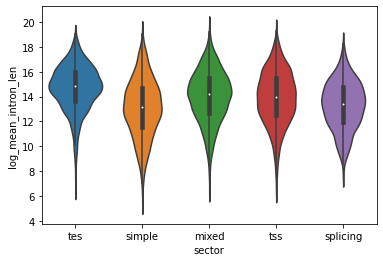

In [234]:
df['log_mean_intron_len'] = np.log2(df['mean_intron_len'])
sns.violinplot(df, y='log_mean_intron_len', x='sector')

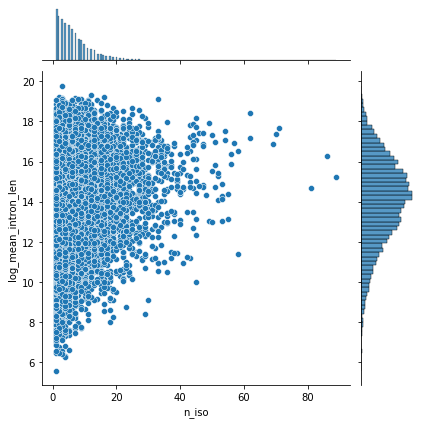

In [235]:
sns.jointplot(df, x='n_iso', y='log_mean_intron_len')

In [237]:
temp = df.loc[~df.log_mean_intron_len.isnull()]
a = temp.n_iso.tolist()
b = temp.log_mean_intron_len.tolist()
st.pearsonr(a,b)

(0.18504212805910153, 3.795367835668529e-130)

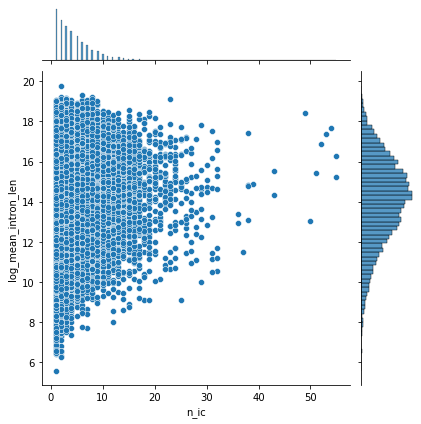

In [236]:
sns.jointplot(df, x='n_ic', y='log_mean_intron_len')

In [238]:
temp = df.loc[~df.log_mean_intron_len.isnull()]
a = temp.n_ic.tolist()
b = temp.log_mean_intron_len.tolist()
st.pearsonr(a,b)

(0.13142936289495047, 4.802453826562423e-66)

## Mean number of introns

In [240]:
# gtf_df = pr.PyRanges(gtf_df)
introns = pr.PyRanges(gtf_df).features.introns(by='transcript').df
introns['len'] = (introns.Start-introns.End).abs()
introns = introns[['gene_id', 'transcript_id', 'len']].groupby(['gene_id', 'transcript_id']).count().reset_index()
introns = introns[['gene_id', 'len']].groupby('gene_id').mean().reset_index().rename({'len':'mean_n_intron'}, axis=1)

In [241]:
introns = cerberus.add_stable_gid(introns)

In [242]:
df = ca.triplets.loc[ca.triplets.source==source].copy()
df = df.merge(introns, how='left', left_on='gid', right_on='gene_id')
df.loc[df.mean_n_intron.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_id,mean_n_intron
586,obs_major,ENSG00000043591,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ADRB1,NaN,NaN,NaN,NaN,NaN
714,obs_major,ENSG00000054598,4.0,3.0,1.0,6.0,0.285714,0.549020,0.411765,0.039216,tss,FOXC1,NaN,NaN,NaN,NaN,NaN
2508,obs_major,ENSG00000101898,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,MCTS2P,NaN,NaN,NaN,NaN,NaN
2549,obs_major,ENSG00000102128,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,RAB40AL,NaN,NaN,NaN,NaN,NaN
3761,obs_major,ENSG00000111432,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,FZD10,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17469,obs_major,ENSG00000284546,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SSU72P3,NaN,NaN,NaN,NaN,NaN
17471,obs_major,ENSG00000284631,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SCYGR4,NaN,NaN,NaN,NaN,NaN
17476,obs_major,ENSG00000284730,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TMDD1,NaN,NaN,NaN,NaN,NaN
17491,obs_major,ENSG00000284976,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ENSG00000284976,NaN,NaN,NaN,NaN,NaN


In [243]:

pairs = list(itertools.combinations(df.sector.unique().tolist(), 2))
c1 = [c[0] for c in pairs]
c2 = [c[1] for c in pairs]

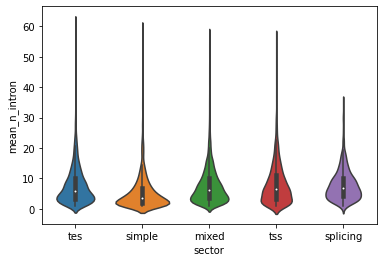

In [244]:
sns.violinplot(df, y='mean_n_intron', x='sector')

In [245]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = df.loc[df.sector==sect1, 'mean_n_intron'].tolist()
    v2 = df.loc[df.sector==sect2, 'mean_n_intron'].tolist()
    result = st.ttest_ind(v1, v2, nan_policy='omit', alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    # print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=1.946150091383587e-47

tes vs. mixed: p=0.7314531693948829

tes vs. tss: p=0.011369585893805753

tes vs. splicing: p=0.1320688914526476

simple vs. mixed: p=1.4360611844284896e-54

simple vs. tss: p=8.673484540263504e-50

simple vs. splicing: p=3.5896880853519574e-39

mixed vs. tss: p=0.001741245740034113

mixed vs. splicing: p=0.07133813746955846

tss vs. splicing: p=0.6555725094869562



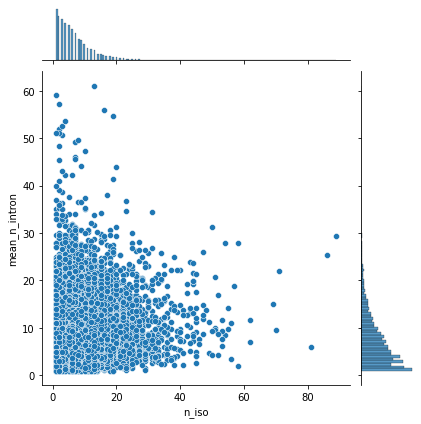

In [246]:
sns.jointplot(df, x='n_iso', y='mean_n_intron')

In [247]:
temp = df.loc[~df.mean_n_intron.isnull()]
a = temp.n_iso.tolist()
b = temp.mean_n_intron.tolist()
st.pearsonr(a,b)

(0.22677655269051836, 3.5582638101155074e-196)

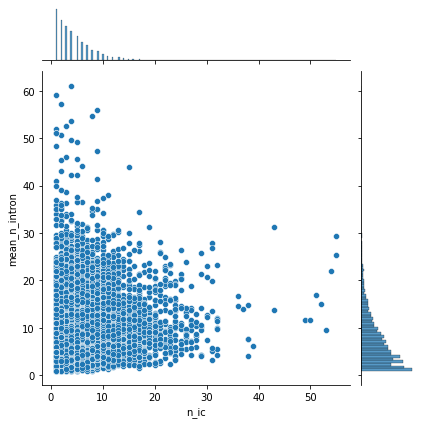

In [249]:
sns.jointplot(df, x='n_ic', y='mean_n_intron')

In [248]:
temp = df.loc[~df.mean_n_intron.isnull()]
a = temp.n_ic.tolist()
b = temp.mean_n_intron.tolist()
st.pearsonr(a,b)

(0.25252702091331064, 2.5748449543771938e-244)

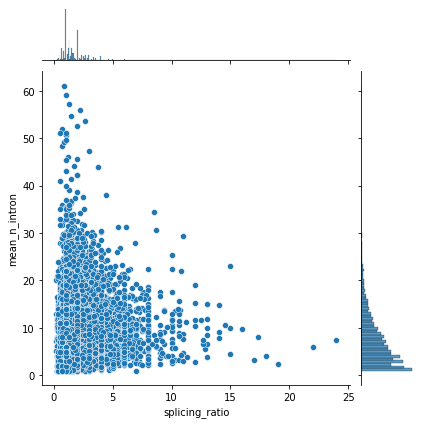

In [250]:
sns.jointplot(df, x='splicing_ratio', y='mean_n_intron')

In [251]:
temp = df.loc[~df.mean_n_intron.isnull()]
a = temp.splicing_ratio.tolist()
b = temp.mean_n_intron.tolist()
st.pearsonr(a,b)

(0.133655971190313, 2.937544790919869e-68)

## Exon len % 3 (internal exons only)

In [194]:
# gtf_df = gtf_df.df
exons = gtf_df.loc[gtf_df.Feature=='exon']

In [195]:
# remove monoexonic or two-exon transcripts
temp = exons[['transcript_id', 'Start']].groupby('transcript_id').count().reset_index().rename({'Start': 'n_exons'}, axis=1)
temp = temp.loc[temp.n_exons>2]
exons = exons.loc[exons.transcript_id.isin(temp.transcript_id.tolist())]

In [196]:
# temp.loc[temp.n_exons==10]

In [197]:
exons = exons.reset_index(drop=True)
# # temporarily
# # exons = exons.loc[exons.transcript_id.isin(['ENSG00000000460[3,10,3]', 'ENSG00000000460[1,10,6]'])]
# # exons.transcript_id.head()

# # exons[keep_cols].loc[exons.transcript_id=='ENSG00000000460[3,10,3]']
# exons[keep_cols].head(25)
# # exons[keep_cols].loc[exons.transcript_id=='ENSG00000000460[1,10,6]']

In [198]:
# restrict to internal exons
drop_inds = exons[['transcript_id']].drop_duplicates(keep='first').index.tolist()+\
            exons[['transcript_id']].drop_duplicates(keep='last').index.tolist()
keep_inds = list(set(exons.index.tolist())-set(drop_inds))
exons = exons.loc[keep_inds]

# compute len of exons
exons['exon_len'] = (exons.Start-exons.End).abs()

In [199]:
exons['exon_len_mod_3'] = exons.exon_len % 3 
exons['frame_preserving'] = exons.exon_len % 3 == 0

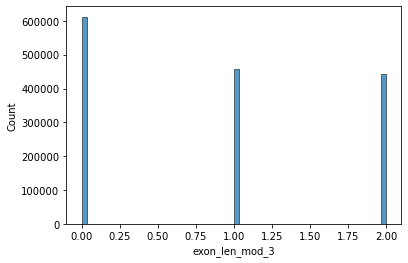

In [200]:
sns.histplot(data=exons, x='exon_len_mod_3')

In [201]:
# % of frame preserving exons / gene
keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'gene_id', 'exon_len_mod_3', 'frame_preserving']
exons = exons[keep_cols].drop_duplicates()

exons.head()

# # total number of exons
# temp = exons['gene_id', 'Start'].groupby('gene_id').count().reset_index().rename({'Start':'n_exons'}, axis=1)
# exons = exons.merge(temp, how='left', on='gene_id')

# # numb
exons = exons[['gene_id', 'frame_preserving']].groupby('gene_id').agg({'frame_preserving': ['count', 'sum']}).reset_index().rename({'count':'n_exons', 
                                                                                                                                   'sum':'n_frame_preserving_exons'}, axis=1)

In [202]:
# exons = exons.columns.droplevel()

In [203]:
exons

gene_id frame_preserving                         
                                   n_exons n_frame_preserving_exons
0      ENSG00000000003.14                6                        6
1       ENSG00000000005.5                5                        3
2      ENSG00000000419.12               11                        4
3      ENSG00000000457.13               13                        6
4      ENSG00000000460.16               25                       13
...                   ...              ...                      ...
19206   ENSG00000285976.1                5                        2
19207   ENSG00000285978.1                6                        3
19208   ENSG00000285980.1                2                        0
19209   ENSG00000285988.1                4                        2
19210   ENSG00000285991.1                4                        3

[19211 rows x 3 columns]

In [207]:
[col[1] for col in exons.columns]
exons.columns = ['gene_id', 'n_exons', 'n_frame_preserving_exons']

In [214]:
exons.loc[exons.n_frame_preserving_exons>exons.n_exons]

,gene_id,n_exons,n_frame_preserving_exons,perc_frame_pres_exons


In [209]:
exons = cerberus.add_stable_gid(exons)
exons['perc_frame_pres_exons'] = (exons.n_frame_preserving_exons/exons.n_exons)*100

In [211]:
df = ca.triplets.loc[ca.triplets.source==source].copy()
df = df.merge(exons, how='left', left_on='gid', right_on='gene_id')
df.loc[df.perc_frame_pres_exons.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_id,n_exons,n_frame_preserving_exons,perc_frame_pres_exons
23,obs_major,ENSG00000002587,5.0,4.0,2.0,6.0,0.444444,0.529412,0.423529,0.047059,tss,HS3ST1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,obs_major,ENSG00000026036,2.0,1.0,3.0,6.0,2.000000,0.400000,0.200000,0.400000,mixed,RTEL1-TNFRSF6B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,obs_major,ENSG00000037965,2.0,2.0,1.0,3.0,0.500000,0.444444,0.444444,0.111111,mixed,HOXC8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560,obs_major,ENSG00000040608,4.0,2.0,3.0,5.0,1.000000,0.571429,0.285714,0.142857,tss,RTN4R,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,obs_major,ENSG00000043591,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ADRB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17480,obs_major,ENSG00000284773,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,ENSG00000284773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17486,obs_major,ENSG00000284895,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000284895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17491,obs_major,ENSG00000284976,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ENSG00000284976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17493,obs_major,ENSG00000285025,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285025,NaN,NaN,NaN,NaN,NaN,NaN,NaN


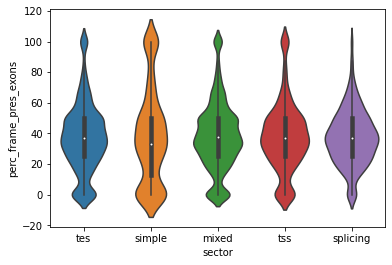

In [212]:
sns.violinplot(df, y='perc_frame_pres_exons', x='sector')

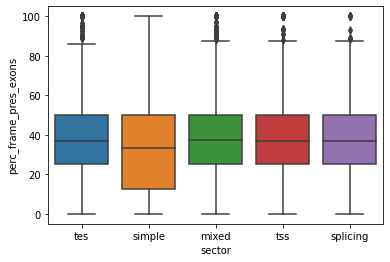

In [215]:
sns.boxplot(df, y='perc_frame_pres_exons', x='sector')

In [216]:
df.loc[df.gname=='ELN']

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_id,n_exons,n_frame_preserving_exons,perc_frame_pres_exons
649,obs_major,ENSG00000049540,3.0,7.0,55.0,89.0,11.0,0.142857,0.333333,0.52381,splicing,ELN,NaN,NaN,NaN,ENSG00000049540,44.0,41.0,93.181818


In [218]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = df.loc[df.sector==sect1, 'perc_frame_pres_exons'].tolist()
    v2 = df.loc[df.sector==sect2, 'perc_frame_pres_exons'].tolist()
    result = st.ttest_ind(v1, v2, nan_policy='omit', alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    # print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=0.1474100295215716

tes vs. mixed: p=0.02694444972932875

tes vs. tss: p=0.4042689566993579

tes vs. splicing: p=0.9914235522262977

simple vs. mixed: p=0.8431935639704096

simple vs. tss: p=0.4948689191213016

simple vs. splicing: p=0.29759055227219156

mixed vs. tss: p=0.38841831316365605

mixed vs. splicing: p=0.1761801207702656

tss vs. splicing: p=0.5219411730069623



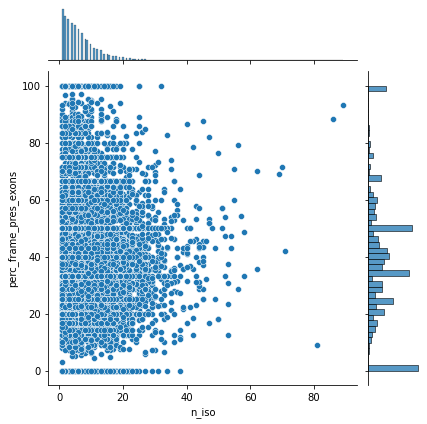

In [220]:
sns.jointplot(df, x='n_iso', y='perc_frame_pres_exons')

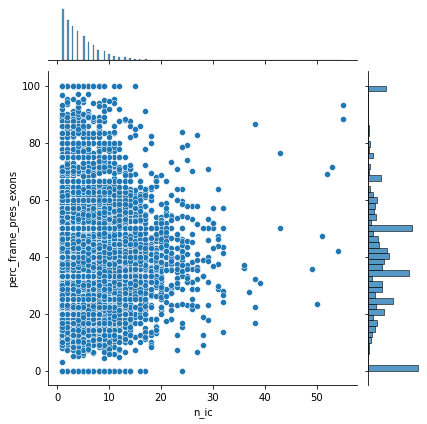

In [221]:
sns.jointplot(df, x='n_ic', y='perc_frame_pres_exons')

In [226]:
temp = df.loc[~df.perc_frame_pres_exons.isnull()]
a = temp.n_ic.tolist()
b = temp.perc_frame_pres_exons.tolist()
st.pearsonr(a,b)

(0.02067180881303774, 0.00880511831950145)

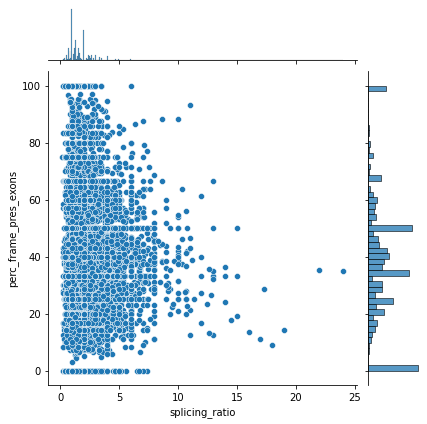

In [223]:
sns.jointplot(df, x='splicing_ratio', y='perc_frame_pres_exons')

In [227]:
temp = df.loc[~df.perc_frame_pres_exons.isnull()]
a = temp.splicing_ratio.tolist()
b = temp.perc_frame_pres_exons.tolist()
st.pearsonr(a,b)

(0.0029535366616484753, 0.7082312151222658)

## Conservation

In [257]:
# "parameters"
min_cons_score = 250

In [258]:
# read conserved elements in, threshold for a certain score
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons = cons[['Chromosome', 'Start', 'End', 'score']]
cons = cons.loc[cons.score >= min_cons_score]
# sns.displot(cons, x='score', kind='kde')
cons = pr.PyRanges(cons)

In [259]:
# read gtf, limit to relevant columns
# only look at exons, calc exon len
gtf_df = pr.read_gtf(gtf, duplicate_attr=True, rename_attr=True).as_df()
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'gene_name',
                 'gene_id', 'transcript_id', 'Feature']]
gtf_df = gtf_df.loc[gtf_df.Feature=='exon']
gtf_df['exon_len'] = (gtf_df.Start-gtf_df.End).abs()

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [260]:
# # temporary - limit to one gene
# myog_df = gtf_df.loc[gtf_df.gene_name=='MYOG']

In [261]:
# myog_df = pr.PyRanges(myog_df)

In [262]:
gtf_df = pr.PyRanges(gtf_df)
gtf_df = gtf_df.join(cons, report_overlap=True)

In [263]:
gtf_df.head()

,Chromosome,Start,End,gene_name,gene_id,transcript_id,Feature,exon_len,Start_b,End_b,score,Overlap
0,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169794925,169794931,255,6
1,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169794994,169795003,323,9
2,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169795023,169795030,268,7
3,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169795036,169795040,333,4
4,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169795064,169795070,361,6
5,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169795102,169795107,363,5
6,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169795108,169795112,295,4
7,chr1,169794679,169795213,C1orf112,ENSG00000000460.16,"ENSG00000000460[3,10,3]",exon,534,169795141,169795146,368,5


In [265]:
gtf_df = gtf_df.df

# get len covered in each exon
keep_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len', 'Overlap']
gb_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len']
temp = gtf_df[keep_cols].groupby(gb_cols, observed=True).sum().reset_index().rename({'Overlap': 'cons_len'}, axis=1)

In [266]:
# get total len of transcript and len covered of each transcript 
keep_cols = ['gene_name', 'gene_id', 'transcript_id', 'exon_len', 'cons_len']
gb_cols = ['gene_name', 'gene_id', 'transcript_id']
temp = temp[keep_cols].groupby(gb_cols,observed=True).sum().reset_index().rename({'exon_len': 't_len'}, axis=1)

In [267]:
# now get median % exonic conservation per gene
temp['perc_cons'] = (temp['cons_len']/temp['t_len'])*100
keep_cols = ['gene_name', 'gene_id', 'perc_cons']
gb_cols = ['gene_name', 'gene_id']
# temp = temp[keep_cols].groupby(gb_cols, observed=True).median().reset_index().rename({'perc_cons':'med_perc_cons'}, axis=1)
temp = temp[keep_cols].groupby(gb_cols, observed=True).mean().reset_index().rename({'perc_cons':'mean_perc_cons'}, axis=1)

In [268]:
temp = cerberus.add_stable_gid(temp)

In [269]:
temp.head()

,gene_name,gene_id,mean_perc_cons
0,5_8S_rRNA,ENSG00000277739,69.565217
1,7SK,ENSG00000202198,79.118329
2,7SK,ENSG00000271394,10.662824
3,7SK,ENSG00000276626,0.872093
4,A1BG,ENSG00000121410,6.297783


In [270]:
# temp.sort_values(by='med_perc_cons', ascending=False).head(50)

In [271]:
# merge median % conservation w/ each gene
ca = cerberus.read(cerberus_h5)

In [272]:
df = ca.triplets.loc[ca.triplets.source==source]

In [273]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset
0,obs_major,ENSG00000000003,1.0,5.0,5.0,12.0,1.666667,0.130435,0.652174,0.217391,tes,TSPAN6,NaN,NaN,NaN
1,obs_major,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN,NaN
2,obs_major,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,0.243902,0.365854,0.390244,mixed,DPM1,NaN,NaN,NaN
3,obs_major,ENSG00000000457,1.0,3.0,3.0,5.0,1.500000,0.181818,0.545455,0.272727,tes,SCYL3,NaN,NaN,NaN
4,obs_major,ENSG00000000460,2.0,4.0,6.0,10.0,2.000000,0.250000,0.500000,0.250000,mixed,C1orf112,NaN,NaN,NaN


In [274]:
df = df.merge(temp, how='left', left_on='gid', right_on='gene_id')

In [275]:
# df.loc[df.med_perc_cons.isnull()]
df.loc[df.mean_perc_cons.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_name,gene_id,mean_perc_cons
148,obs_major,ENSG00000006659,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,LGALS14,NaN,NaN,NaN,NaN,NaN,NaN
219,obs_major,ENSG00000008517,3.0,2.0,18.0,22.0,7.200000,0.245902,0.163934,0.590164,splicing,IL32,NaN,NaN,NaN,NaN,NaN,NaN
4918,obs_major,ENSG00000120664,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SPART-AS1,NaN,NaN,NaN,NaN,NaN,NaN
6273,obs_major,ENSG00000132204,2.0,2.0,3.0,3.0,1.500000,0.363636,0.363636,0.272727,mixed,LINC00470,NaN,NaN,NaN,NaN,NaN,NaN
6386,obs_major,ENSG00000132832,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000132832,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26753,obs_major,ENSG00000285829,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285829,NaN,NaN,NaN,NaN,NaN,NaN
26763,obs_major,ENSG00000285886,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285886,NaN,NaN,NaN,NaN,NaN,NaN
26771,obs_major,ENSG00000285933,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ENSG00000285933,NaN,NaN,NaN,NaN,NaN,NaN
26774,obs_major,ENSG00000285958,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285958,NaN,NaN,NaN,NaN,NaN,NaN


In [276]:
len(df.index)

26781

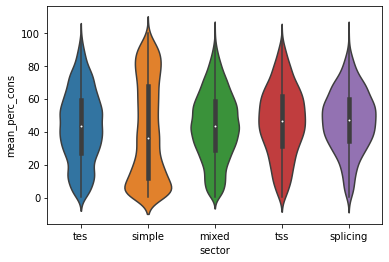

In [278]:
sns.violinplot(df, y='mean_perc_cons', x='sector')

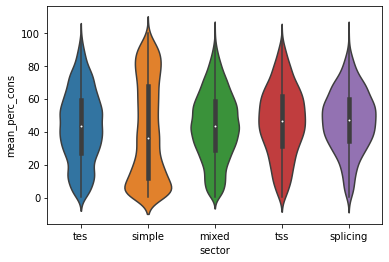

In [279]:
sns.violinplot(df, y='mean_perc_cons', x='sector')

In [280]:

pairs = list(itertools.combinations(df.sector.unique().tolist(), 2))
c1 = [c[0] for c in pairs]
c2 = [c[1] for c in pairs]

In [281]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = df.loc[df.sector==sect1, 'mean_perc_cons'].tolist()
    v2 = df.loc[df.sector==sect2, 'mean_perc_cons'].tolist()
    result = st.ttest_ind(v1, v2, nan_policy='omit', alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    # print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=3.2404904228869825e-08

tes vs. mixed: p=0.408297829875265

tes vs. tss: p=1.733884647972452e-08

tes vs. splicing: p=3.04127119899442e-06

simple vs. mixed: p=5.008744929228302e-15

simple vs. tss: p=1.2172398007838406e-19

simple vs. splicing: p=7.696064173514828e-11

mixed vs. tss: p=8.659689838999978e-09

mixed vs. splicing: p=3.7250847216358148e-06

tss vs. splicing: p=0.5670390989484096



In [283]:
# for sect1, sect2 in zip(c1, c2):
#     v1 = df.loc[df.sector==sect1, 'med_perc_cons'].tolist()
#     v2 = df.loc[df.sector==sect2, 'med_perc_cons'].tolist()
#     result = st.ttest_ind(v1, v2, nan_policy='omit', alternative='two-sided')
#     p = result.pvalue
#     stat = result.statistic
#     # print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
#     print(f'{sect1} vs. {sect2}: p={p}')
#     print()

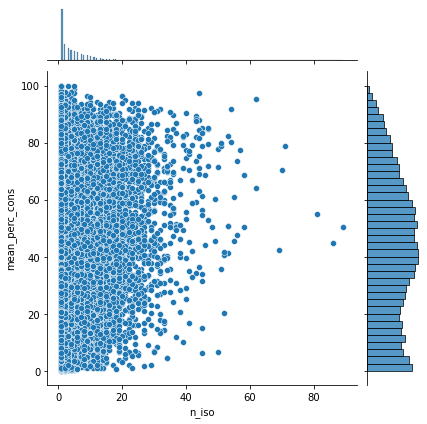

In [287]:
sns.jointplot(df, x='n_iso', y='mean_perc_cons')

In [288]:
temp = df.loc[~df.mean_perc_cons.isnull()]
a = temp.n_iso.tolist()
b = temp.mean_perc_cons.tolist()
st.pearsonr(a,b)

(0.15589736727364045, 3.168471281113695e-138)

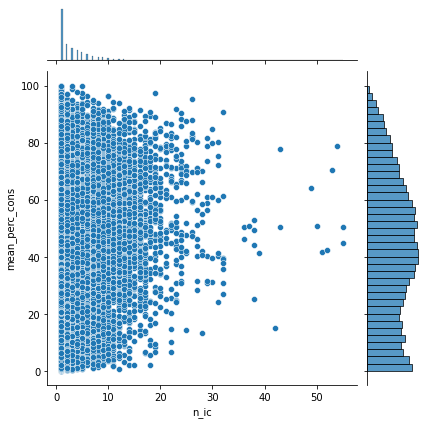

In [289]:
sns.jointplot(df, x='n_ic', y='mean_perc_cons')

In [290]:
temp = df.loc[~df.mean_perc_cons.isnull()]
a = temp.n_ic.tolist()
b = temp.mean_perc_cons.tolist()
st.pearsonr(a,b)

(0.152695122710399, 1.274900883967693e-132)

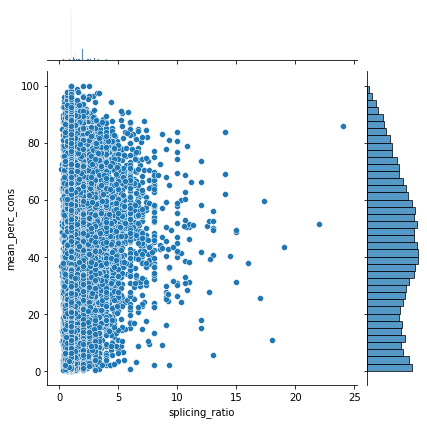

In [292]:
sns.jointplot(df, x='splicing_ratio', y='mean_perc_cons')

In [293]:
temp = df.loc[~df.mean_perc_cons.isnull()]
a = temp.splicing_ratio.tolist()
b = temp.mean_perc_cons.tolist()
st.pearsonr(a,b)

(0.08753912636017341, 1.706905324404282e-44)

In [28]:
# myog_df = gtf_df.loc[gtf_df.gene_name == 'MYOG']
# myog_df = myog_df.loc[myog_df.Feature=='exon'][['Chromosome', 'Start', 'End']]
# myog_df = pr.PyRanges(myog_df)
# temp = myog_df.join(cons, report_overlap=True)
# sns.displot(temp, x='score')

In [23]:
cons.loc[cons.score<250]

,bin,Chromosome,Start,End,idk1,score
12,585,chr1,12985,12992,lod=13,247
18,585,chr1,13060,13062,lod=13,247
31,585,chr1,14118,14127,lod=13,247
33,585,chr1,14179,14184,lod=13,247
46,585,chr1,14798,14800,lod=12,240
...,...,...,...,...,...,...
10350657,1021,chrY,57195484,57195541,lod=13,247
10350660,1021,chrY,57196338,57196341,lod=13,247
10350673,1021,chrY,57208720,57208727,lod=13,247
10350705,1021,chrY,57211798,57211800,lod=13,247


In [18]:
temp = temp.df

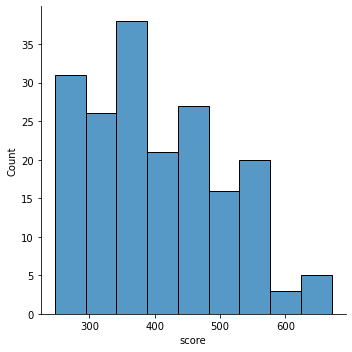

In [20]:
# get the exons from the reference GTF
gtf_df = pr.read_gtf(gtf, as_df=True, duplicate_attr=True, rename_attr=True)

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [15]:
s = 'splicing'
source = 'obs_major'
df = ca.triplets.loc[(ca.triplets.source==source)&(ca.triplets.sector==s)]

In [16]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset
12,obs_major,ENSG00000001497,1.0,2.0,7.0,7.0,4.666667,0.130435,0.260870,0.608696,splicing,LAS1L,NaN,NaN,NaN
20,obs_major,ENSG00000002330,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,BAD,NaN,NaN,NaN
22,obs_major,ENSG00000002586,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,splicing,CD99,NaN,NaN,NaN
51,obs_major,ENSG00000004487,2.0,1.0,7.0,7.0,4.666667,0.260870,0.130435,0.608696,splicing,KDM1A,NaN,NaN,NaN
84,obs_major,ENSG00000005189,1.0,2.0,8.0,9.0,5.333333,0.120000,0.240000,0.640000,splicing,REXO5,NaN,NaN,NaN


In [20]:
cons = cons.df

In [22]:
cons.loc[cons.score < 300]
cons.score.min()

186

## Splicing factors

In [37]:
sf_df = pd.read_csv(sfs, sep='\t')
sf_df.head()
gids = sf_df['Gene stable ID'].tolist()

In [46]:
df = ca.triplets.loc[(ca.triplets.source=='obs_major')&(ca.triplets.gid.isin(gids))]
df = df[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'},axis=1)
df['total'] = df.n_genes.sum(axis=0)
df['perc'] = (df.n_genes/df.total)*100
df

,sector,n_genes,total,perc
0,mixed,222,454,48.898678
1,simple,32,454,7.048458
2,splicing,32,454,7.048458
3,tes,112,454,24.669604
4,tss,56,454,12.334802


In [48]:
df2 = ca.triplets.loc[(ca.triplets.source=='obs_major')]
df2 = df2[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'},axis=1)
df2['total'] = df2.n_genes.sum(axis=0)
df2['perc'] = (df2.n_genes/df2.total)*100
df2

,sector,n_genes,total,perc
0,mixed,9106,26781,34.001718
1,simple,9092,26781,33.949442
2,splicing,1076,26781,4.017774
3,tes,4832,26781,18.042642
4,tss,2675,26781,9.988425


## GO terms

In [26]:
ca = cerberus.read(cerberus_h5)

In [29]:
rna_binding_genes = 'EIF4A2;RBM28;DDX49;TES;KDM1A;NVL;RTCA;AKAP8L;C4BPA;HNRNPR;NOC2L;APEH;RPL10A;WDR46;RRP9;PSMD4;RAVER1;RPL18A;ARL6IP4;MRPL9;BUD23;NELFE;MRPS28;TOP3B;RBM14;RPS9;NSUN5;METTL3;POLRMT;SAFB;SRP9;RPP25L;DNM1;DHX40;DDX39A;DALRD3;SARS2;EWSR1;UNC50;XRN2;RPP21;RPL24;SRSF4;S100A4;DXO;ARHGEF1;SNRPA1;SRSF5;RPL26;CARS1;SNRPC;SRSF7;DUS3L;RPS19BP1;KARS1;PEF1;POLDIP3;SRBD1;RBM4B;SLC3A2;MRM1;TBRG4;EXOSC10;TCOF1;PUF60;PCBP4;EXOSC9;ERI3;XIRP1;POLR2G;TOE1;FDPS;RPL41;MCRS1;CNBP;NONO;MRPL27;TRMT1;ERAL1;PUM1;HNRNPAB;HARS2;SNUPN;MRPL21;NAP1L4;CS;HNRNPM;NLRP11;LIN28A;LAS1L;APEX1;TRIP6;NOL11;ALDH18A1;RBM45'.split(';')

In [30]:
df = ca.triplets.loc[(ca.triplets.gname.isin(rna_binding_genes))&(ca.triplets.source=='obs_major')]

In [33]:
df.sort_values(by='gname')[['gname', 'sector']].sector.unique()

array(['splicing'], dtype=object)

In [4]:
def do_go_thing(df, opref):
    dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
    bm = gp.parser.Biomart()
    datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    datasets.loc[datasets.Description.str.contains('Human')]
    
    for s in df.sector.unique():
        print(s)
        desc = '{} genes'.format(s)
        odir = '{}{}_genes_GO'.format(opref, s)
        gids = df.loc[df.sector == s, 'gid'].tolist()
        gids = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id', 'external_gene_name'],
               filters={'ensembl_gene_id': gids})
        gids = gids.loc[~gids.external_gene_name.isna()]
        gnames = gids.external_gene_name.squeeze().str.strip().tolist()
        go = gp.enrichr(gene_list=gnames,
                        gene_sets=dbs,
                        organism='Human',
                        description=desc,
                        outdir=odir,
                        cutoff=0.5)

In [5]:
ca = cerberus.read(cerberus_h5)

In [8]:
source = 'obs_major'
df = ca.triplets.loc[ca.triplets.source == source]

# limit to protein coding genes
gtf_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gids = gtf_df.loc[gtf_df.biotype_category=='protein_coding', 'gid_stable'].tolist()
print(len(df.index))
df = df.loc[df.gid.isin(gids)]
print(len(df.index))

26781
17523


In [9]:
do_go_thing(df, 'obs_major_')

tes
simple
mixed
tss
splicing


In [5]:
def rm_go_number(df):
    df['term'] = df['Term'].str.split('\(GO', expand=True)[0]
    return df

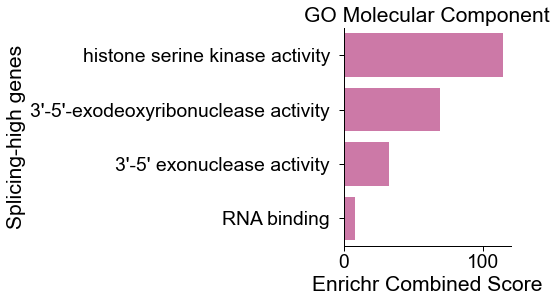

In [17]:
# tes - show molecular function
df = pd.read_csv('obs_major_splicing_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
df = df.sort_values(by='Adjusted P-value', ascending=True)
n = 4
kind = 'splicing'
df = df.head(n)
df = df.sort_values(by='Combined Score', ascending=False)

df = rm_go_number(df)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'Splicing-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_splicing_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

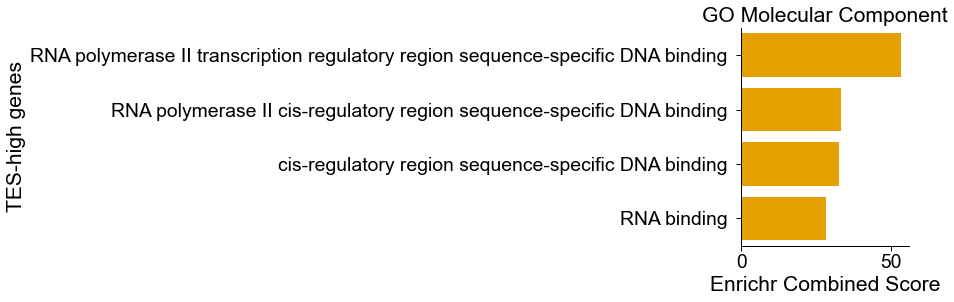

In [18]:
# tes - show molecular function
df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
df = df.sort_values(by='Adjusted P-value', ascending=True)
n = 4
kind = 'tes'
df = df.head(n)
df = df.sort_values(by='Combined Score', ascending=False)

df = rm_go_number(df)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TES-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

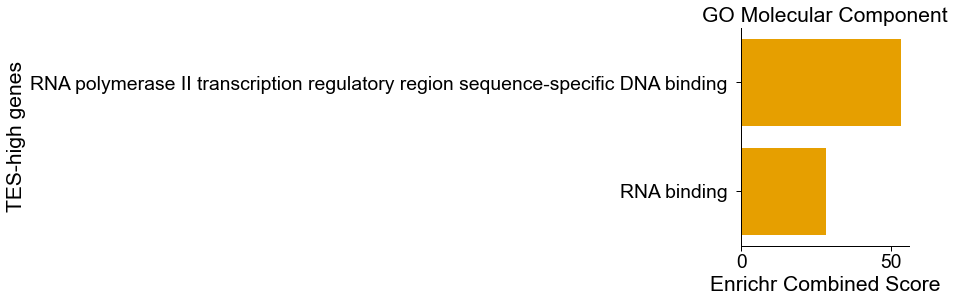

In [25]:
# tes - show molecular function
df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
# df = df.sort_values(by='Adjusted P-value', ascending=True)
# n = 2
kind = 'tes'
# df = df.head(n)
df = df.iloc[[0,3]]

df = df.sort_values(by='Combined Score', ascending=False)

df = rm_go_number(df)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TES-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

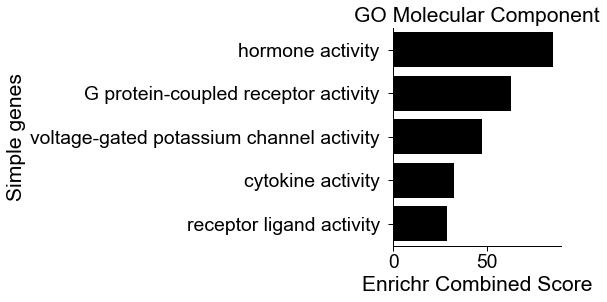

In [22]:
# simple - show molecular function
df = pd.read_csv('obs_major_simple_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 5
kind = 'simple'
df = df.head(n)
df = df.sort_values(by='Adjusted P-value', ascending=True)

df = rm_go_number(df)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'Simple genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_simple_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

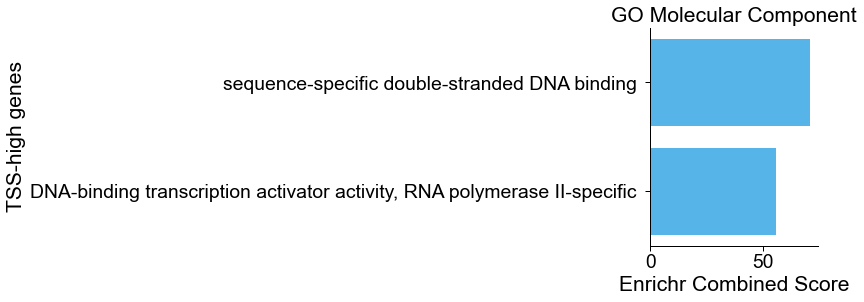

In [23]:
# tss - show molecular function
df = pd.read_csv('obs_major_tss_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 6
kind = 'tss'
df = df.iloc[[0,3]]
df = rm_go_number(df)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TSS-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tss_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

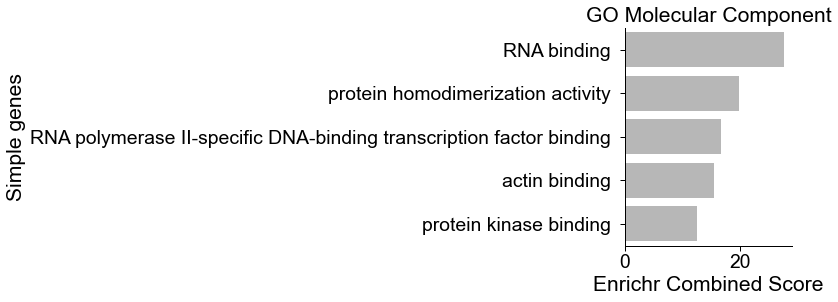

In [24]:
# mixed - show molecular function
df = pd.read_csv('obs_major_mixed_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 5
kind = 'mixed'
df = df.head(n)
df = df.sort_values(by='Adjusted P-value', ascending=True)

df = rm_go_number(df)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'Simple genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_mixed_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')